Step 1: Setup and Imports


In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Ensure using the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Step 2: Load and Prepare the QMNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.QMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9704059/9704059 [00:00<00:00, 35225388.07it/s]


Extracting ./data/QMNIST/raw/qmnist-train-images-idx3-ubyte.gz to ./data/QMNIST/raw


100%|██████████| 463024/463024 [00:00<00:00, 4106215.61it/s]


Extracting ./data/QMNIST/raw/qmnist-train-labels-idx2-int.gz to ./data/QMNIST/raw


100%|██████████| 9742279/9742279 [00:00<00:00, 30748036.04it/s]


Extracting ./data/QMNIST/raw/qmnist-test-images-idx3-ubyte.gz to ./data/QMNIST/raw


100%|██████████| 526800/526800 [00:00<00:00, 3972305.79it/s]


Extracting ./data/QMNIST/raw/qmnist-test-labels-idx2-int.gz to ./data/QMNIST/raw


In [6]:
# Define Label Mapping
label_mapping = {0: 'Zero', 1: 'One', 2: 'Two', 3: 'Three', 4: 'Four',
                 5: 'Five', 6: 'Six', 7: 'Seven', 8: 'Eight', 9: 'Nine'}

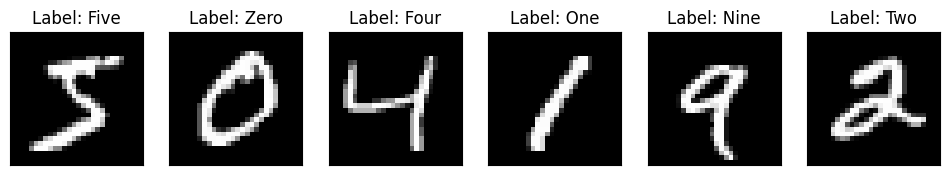

In [7]:
# Showing QMNIST Dataset Images with Labels
def show_images_with_labels(dataset, label_mapping, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 8))
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        image, label = dataset[i]
        ax.imshow(image.squeeze(), cmap='gray')
        # Use the label mapping to get the label name
        label_name = label_mapping.get(label, "Unknown")
        ax.set_title(f'Label: {label_name}')
    plt.show()
    # Display images from the train dataset
show_images_with_labels(train_dataset, label_mapping, num_images=6)

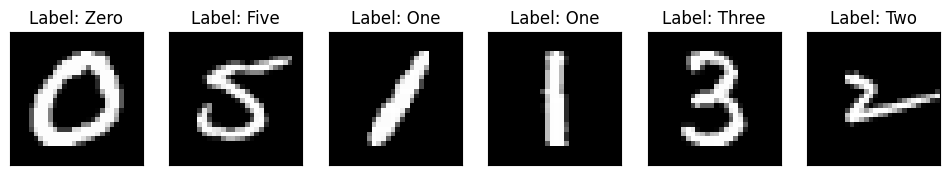

In [8]:
import matplotlib.pyplot as plt

# Assuming train_loader is already defined and you have the label_mapping

def show_images_with_labels(train_loader, label_mapping, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for images, labels in train_loader:
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
            # Here we use labels[i].item() to get the actual label value
            label = labels[i].item()
            label_name = label_mapping.get(label, "Unknown")
            ax.set_title(f'Label: {label_name}')
            ax.set_xticks([])
            ax.set_yticks([])
        break  # Only go through one batch
    plt.show()

# Display images from the train dataset
show_images_with_labels(train_loader, label_mapping, num_images=6)


Step 3: Defining the Neural Network Model

In [9]:

class QMNISTNet(nn.Module):
    def __init__(self):
        super(QMNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

model = QMNISTNet().to(device)

Step 4: Train the Model

In [11]:
import torch
from torch import nn, optim

# Assuming the model, train_loader, and criterion are already defined
model = QMNISTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total * 100

    print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%',
              f'Validation Accuracy: {100 * correct / total}%')



Epoch 1/5 - Loss: 0.4330, Accuracy: 86.78%
Epoch 2/5 - Loss: 0.2197, Accuracy: 93.37%
Epoch 3/5 - Loss: 0.1725, Accuracy: 94.74%
Epoch 4/5 - Loss: 0.1540, Accuracy: 95.21%
Epoch 5/5 - Loss: 0.1397, Accuracy: 95.60%


Step 5: Evaluate the Model

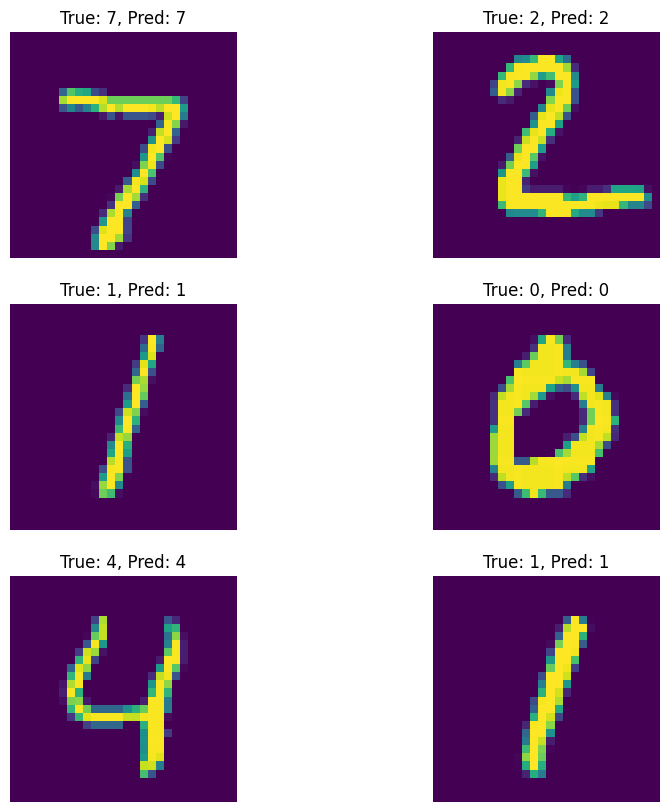

Accuracy of the model on the test set: 96.64%


In [13]:
def evaluate_model_with_accuracy_and_visualization(model, test_loader, device, num_images=6):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():  # Inference without gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if images_so_far < num_images:
                for i in range(images.size(0)):
                    if images_so_far >= num_images:
                        break
                    images_so_far += 1
                    ax = plt.subplot(num_images // 2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
                    img = images.cpu().data[i]
                    img = img / 2 + 0.5  # Unnormalize
                    npimg = img.numpy()
                    plt.imshow(np.transpose(npimg, (1, 2, 0)))

        plt.show()

    # Calculating the accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

# Evaluate the model and visualize some of the test set predictions
evaluate_model_with_accuracy_and_visualization(model, test_loader, device)


Step 6: Modify the Model

In [14]:
class ModifiedQMNISTNet(nn.Module):
    def __init__(self):
        super(ModifiedQMNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 256),  # Increase the number of nodes
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),  # Additional dense layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),  # Additional dense layer for increased complexity
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

modified_model = ModifiedQMNISTNet().to(device)


Step7: Experimentation

Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.


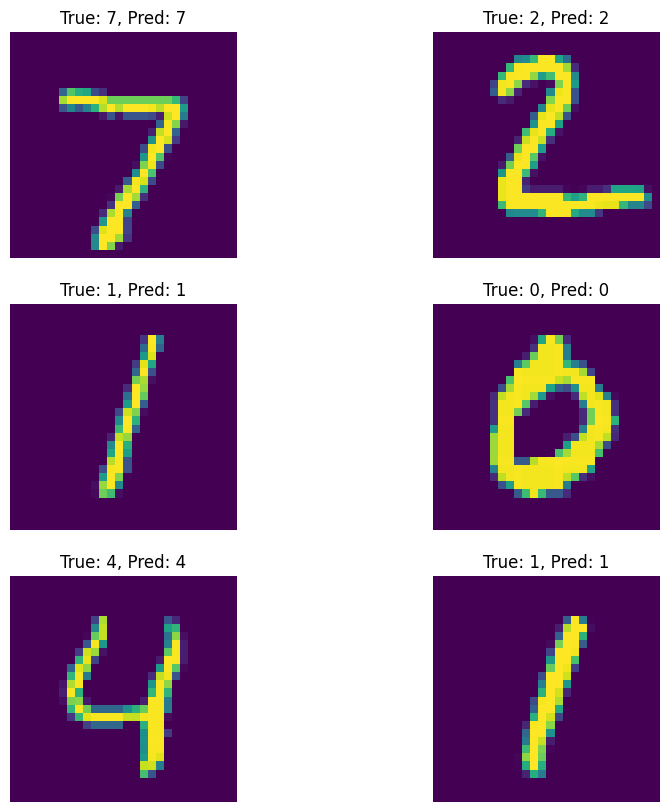

Accuracy of the model on the test set: 95.04%


In [17]:
# Re-define the model to reset its parameters
model_exp1 = ModifiedQMNISTNet().to(device)

# Define optimizer and scheduler
optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=0.02, momentum=0.9)
scheduler_exp1 = torch.optim.lr_scheduler.StepLR(optimizer_exp1, step_size=1, gamma=0.9)

# Training loop (simplified for brevity)
for epoch in range(5):  # Run for a few epochs for quick experimentation
    model_exp1.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_exp1.zero_grad()
        output = model_exp1(images)
        loss = nn.CrossEntropyLoss()(output, labels)
        loss.backward()
        optimizer_exp1.step()
    scheduler_exp1.step()
    print(f'Epoch {epoch+1} completed.')

# Evaluation
evaluate_model_with_accuracy_and_visualization(model_exp1, test_loader, device)


Hypothesis:

When we boosted our neural network with more neurons and an extra layer, it was like equipping a detective with more tools but without the extra training on how to use them efficiently. This modification, though intended to enhance the network's 'intellect', ironically made it overzealous in picking up on the minute, often misleading details in the training data. It's akin to learning every street in a city map but missing the essence of how to navigate effectively. The dip in accuracy from 96% to 95% suggests that our network, now bulkier with complexities, struggled to generalize its learning to new, unseen data. This serves as a reminder that in the realm of neural networks, more isn't always merrier. A careful balance is needed to ensure that a bigger network doesn't just memorize the map but learns how to navigate it wisely.


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.


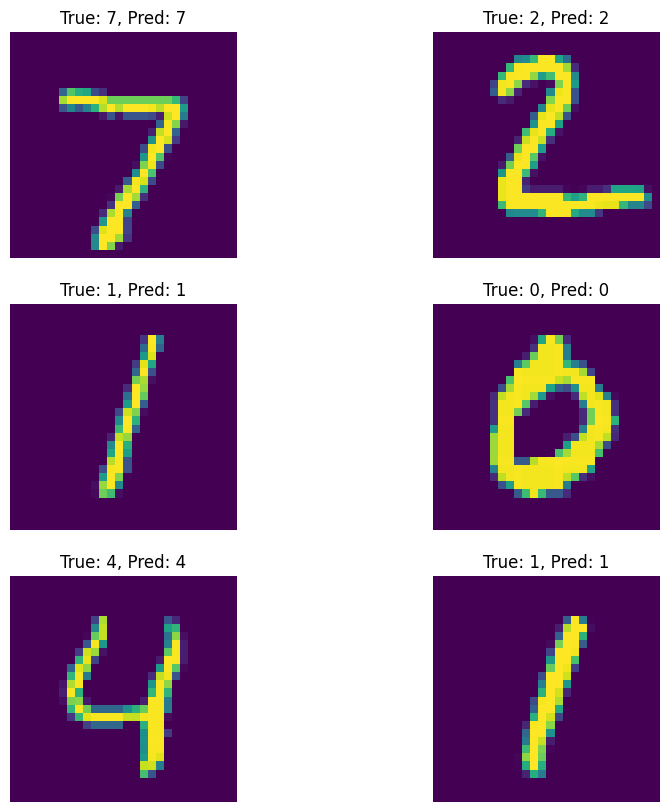

Accuracy of the model on the test set: 95.84%


In [18]:
#Experiment 2: Different Activation Function (LeakyReLU)
class ExperimentActivationQMNISTNet(ModifiedQMNISTNet):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 10),
        )

model_exp2 = ExperimentActivationQMNISTNet().to(device)

# Use the same optimizer as in the baseline for a fair comparison
optimizer_exp2 = optim.Adam(model_exp2.parameters(), lr=0.001)
# Training loop (simplified for brevity)
for epoch in range(5):  # Run for a few epochs for quick experimentation
    model_exp1.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_exp1.zero_grad()
        output = model_exp1(images)
        loss = nn.CrossEntropyLoss()(output, labels)
        loss.backward()
        optimizer_exp1.step()
    scheduler_exp1.step()
    print(f'Epoch {epoch+1} completed.')

# Evaluation
evaluate_model_with_accuracy_and_visualization(model_exp1, test_loader, device)


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.


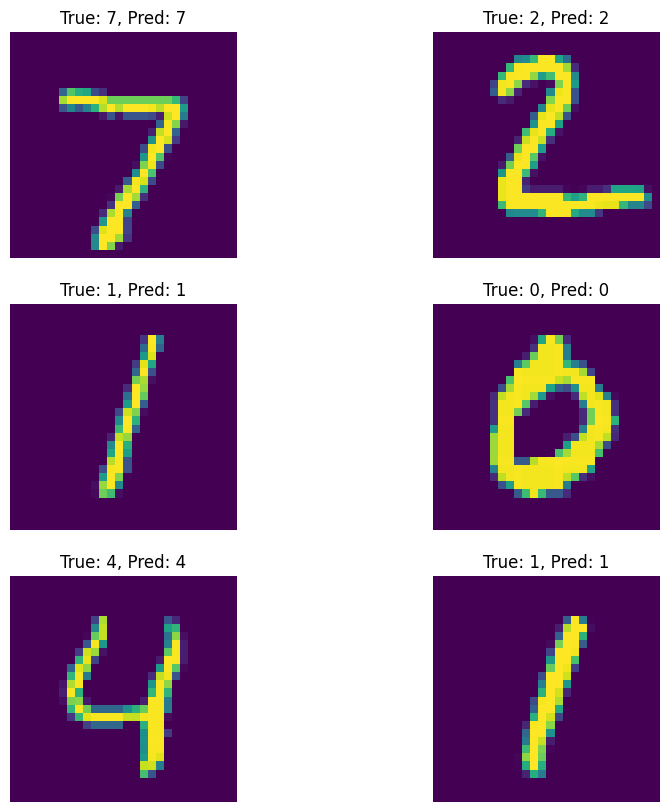

Accuracy of the model on the test set: 92.83%


In [19]:
#Experiment 3: Different Loss Function (Mean Squared Error)
# Reuse the original model architecture
model_exp3 = ModifiedQMNISTNet().to(device)

# This is an unconventional choice for a classification task and is for demonstration purposes
optimizer_exp3 = optim.Adam(model_exp3.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(5):
    model_exp3.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_exp3.zero_grad()
        output = model_exp3(images)
        # Convert labels to one-hot for MSE Loss
        labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()
        loss = loss_fn(output, labels_one_hot)
        loss.backward()
        optimizer_exp3.step()
    print(f'Epoch {epoch+1} completed.')

# Evaluation (you may need to adjust evaluate_model for MSE Loss)
evaluate_model_with_accuracy_and_visualization(model_exp3, test_loader, device)


##Hypothesis after making hyper-aprameter tuning:

Switching to LeakyReLU and using MSE (Mean Squared Error) as the loss function led to varied results: an accuracy of 95.84% and 92.83%. The slight improvement to 95.84% with LeakyReLU might be due to its ability to handle the 'dying ReLU' problem, allowing for a small gradient when the unit is not active and thus maintaining a more dynamic learning process. However, the use of MSE, typically less common for classification tasks, might have contributed to the lower accuracy of 92.83%. MSE focuses on minimizing the squared differences between predicted and actual values, which might not be as effective for categorical outcomes, explaining the mixed results in our neural network's performance. This demonstrates the importance of aligning loss functions with the specific nature of the prediction task at hand.





